#Lecture 18: Hidden Markov Models

AM207: Pavlos Protopapas, Harvard University


------


A simple and effective method of representing observations in the real world is as noisy reflections of a 'true' state. For example, the stock price can be considered a noisy reflection of the actual value of the company. Or, the way you feel on a certain day can be thought of as a noisy relfection of whether of not you have a fever (For instance, sometimes you may feel cold or dizzy even if you aren't sick).

Modeling a time series of events in such a way is called a Hidden Markov Model (HMM). There are the observed states and the latent states that determine them. There is some emmission probability of observed states given the latent state at each time step. There is a also a transition probability between latent states. Consider the below illustration, with x being the latent state and y being the observed state at each time step. The arrows indicate transitions which are decided by a transition probability distribution.

<img src="./Lecture18_data/hmm.png" height="150px">

There are three fundamental problems for HMMs:

1. Evaluation: Given the model parameters and observed data, calculate the likelihood of the data.

2. Decoding: Given the model parameters and observed data, estimate the optimal sequence of hidden states.

3. Learning: Given just the observed data, estimate the model parameters.

# Evaluation

The goal of the evaluation problem is to return the probability of a given sequence of observations given a sequence of latent states. Let us first introduce the toy problem. In this problem, we consider a person's latent state of health and their apparent symptoms. In this instance, a person is either Healthy or has a Fever, and the possible symptoms are feeling normal, cold, and dizzy. There is no deterministic relationship between the latent and observed states, so we need probabilistic approach to solving the problem of evaluation. 

<img src="./Lecture18_data/hmm1.png" height="500px">

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

In [2]:
states = ('Healthy', 'Fever')
end_state = 'E'
 
observations = ('cold', 'normal', 'normal')
 
start_probability = {'Healthy': 0.6, 'Fever': 0.4}

transition_probability = {
   'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6},
   }
 
emission_probability = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
   }

## Forward-Backward Algorithm

Now that we have the model with transition probabilities in place, we need a way to determine the likelihood of a certain series of observations. In the above example, the observations are feeling cold the first day and normal the next two.

In the first pass, the forward–backward algorithm computes a set of forward probabilities which provide, for all $k \in \{1, \dots, t\}$, the probability of ending up in any particular state given the first $k$ observations in the sequence, i.e. $P(X_k\ |\  Y_{1:k})$. In the second pass, the algorithm computes a set of backward probabilities which provide the probability of observing the remaining observations given any starting point $k$, i.e. $P(Y_{k+1:t}\ |\ X_k)$. These two sets of probability distributions can then be combined to obtain the distribution over states at any specific point in time given the entire observation sequence:

$P(X_k\ |\ Y_{1:t}) = P(X_k\ |\ Y_{1:k}, Y_{k+1:t}) \propto P(Y_{k+1:t}\ |\ X_k) P(X_k\ |\ Y_{1:k})$

The last step follows from an application of Bayes' rule and the conditional independence of $Y_{k+1:t}$ and $Y_{1:k}$ given $X_k$.

As outlined above, the algorithm involves three steps:

1. computing forward probabilities

2. computing backward probabilities

3. computing smoothed values.

The forward and backward steps may also be called "forward message pass" and "backward message pass" - these terms are due to the message-passing used in general belief propagation approaches. At each single observation in the sequence, probabilities to be used for calculations at the next observation are computed. The smoothing step can be calculated simultaneously during the backward pass. This step allows the algorithm to take into account any past observations of output for computing more accurate results.

The forward–backward algorithm can be used to find the most likely state for any point in time. It cannot, however, be used to find the most likely sequence of states (see Decoding, and specifically the Viterbi algorithm).

In [3]:
def fwd_bkw(y, states, a_0, a, e):
    L = len(y)
 
    fwd = []
    f_prev = {}
    # forward part of the algorithm
    for i, y_i in enumerate(y):
        f_curr = {}
        for st in states:
            if i == 0:
                # base case for the forward part
                prev_f_sum = a_0[st]
            else:
                prev_f_sum = sum(f_prev[k]*a[k][st] for k in states)
 
            f_curr[st] = e[st][y_i] * prev_f_sum
 
        fwd.append(f_curr)
        f_prev = f_curr
 
    bkw = []
    b_prev = {}
    # backward part of the algorithm
    for i, y_i_plus in enumerate(reversed(y[1:]+(None,))):
        b_curr = {}
        for st in states:
            if i == 0:
                # base case for backward part
                b_curr[st] = 1.0
            else:
                b_curr[st] = sum(a[st][l]*e[l][y_i_plus]*b_prev[l] for l in states)
 
        bkw.insert(0,b_curr)
        b_prev = b_curr
 
    p_bkw = sum(a_0[l] * e[l][y[0]] * b_curr[l] for l in states)
 
    # merging the two parts
    posterior = []
    for i in range(L):
        posterior.append({st: fwd[i][st]*bkw[i][st]/p_bkw for st in states})
 
    return fwd, bkw, posterior

In [4]:
def example():
    return fwd_bkw(observations,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability)
 
fwd, bkw, posterior = example()
print posterior

[{'Healthy': 0.7545551982851018, 'Fever': 0.24544480171489824}, {'Healthy': 0.9163987138263665, 'Fever': 0.08360128617363344}, {'Healthy': 0.9083601286173633, 'Fever': 0.09163987138263664}]


# Decoding

Decoding an HMM is answering the question: "Given the transition model, what is the most likely sequence of latent states that could have produced the observed states?" This is different than the evaulation problem because it predicts an entire sequence rather than giving a probability distribution over the latent states for each time step. 

A naive way of solving the decoding problem is simply by exhausting evaulation, i.e. to list all possible sequences of hidden states and finding the probability of the observed sequence for each of the combinations. The most probable sequence of hidden states is that combination that maximises P(observed sequence | hidden state sequence).

This approach is viable, but to find the most probable sequence by exhaustively calculating each combination is computationally expensive. As with the forward algorithm, we can use the time invariance of the probabilities to reduce the complexity of the calculation.


# Viterbi

The most popular algorithm for the HMM  decoding problem is the Viterbi algorithm, a dynamic programming solution (for the most likely set of hidden states). Viterbi recursively finds the most probable sequence of hidden states given an observation sequence and a HMM. It does it by first defining the partial probability  $d$, which is the probability of reaching a particular intermediate state in the time sequence. These partial probabilities differ from those calculated in the forward algorithm since they represent the probability of the most probable path to a state at time $t$, and not a total. Thus $d (X_i,t)$ is the maximum probability of all sequences ending at state $X_i$ at time $t$, and the partial best path is the sequence which achieves this maximal probability. Thus, to calculate the partial probabilities $d$ at time $t$, we only need to know the probabilties $d$ at time $t-1$. 

$$d(X_i, t) = \max_{\forall j}(d(X_j, t-1) \times P(X_j,X_i))$$

In the below implementation, the accuracy is assessed by generating the hidden and observed states ourselves and then comparing them against the Viterbi proposal.

In [5]:
# a slightly more realistic version of the 'Healthy' vs. 'Fever' model is outlined and then generated
import random
states = ('Healthy', 'Fever')
observations = ('normal', 'cold', 'dizzy')
start_probability = {'Healthy': 0.6, 'Fever': 0.4}

transition_probability = {
   'Healthy' : {'Healthy': 0.8, 'Fever': 0.2},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6}
   }

emission_probability = {
   'Healthy' : {'normal': 0.7, 'cold': 0.2, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.4, 'dizzy': 0.5}
   }

# A random HMM is generated using the probability matricies defined above
# Both the latent and visible states are generated in order to later assess the accuracy of our algorithms
N = 100
hidden = []
visible = []
# generate observations
if random.random() < start_probability[states[0]]:
    hidden.append(states[0])
else:
    hidden.append(states[1])

for i in xrange(N):
    current_state = hidden[i]
    if random.random() < transition_probability[current_state][states[0]]:
        hidden.append(states[0])
    else:
        hidden.append(states[1])
    r = random.random()
    prev = 0
    for observation in observations:
        prev += emission_probability[current_state][observation]
        if r < prev:
            visible.append(observation)
            break

# fixes issue of creating extra hidden state
hidden.pop()

'Healthy'

In [13]:
def print_dptable(V):
    s = "    " + " ".join(("%7d" % i) for i in range(len(V))) + "\n"
    for y in V[0]:
        s += "%.5s: " % y
        s += " ".join("%.7s" % ("%f" % v[y]) for v in V)
        s += "\n"
    print(s)

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}
 
    # Initialize base cases (t == 0)
    for y in states:
        V[0][y] = start_p[y] * emit_p[y][obs[0]]
        path[y] = [y]
 
    # Run Viterbi for t > 0
    for t in range(1, len(obs)):
        V.append({})
        newpath = {}
 
        for y in states:
            (prob, state) = max((V[t-1][y0] * trans_p[y0][y] * emit_p[y][obs[t]], y0) for y0 in states)
            V[t][y] = prob
            newpath[y] = path[state] + [y]
 
        # Don't need to remember the old paths
        path = newpath
     
    #print_dptable(V)
    (prob, state) = max((V[t][y], y) for y in states)
    return (prob, path[state])

# input the generated markov model
def example():
    return viterbi(visible,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability)

(prob, p_hidden) = example()

# assess accuracy of the HMM model
wrong= 0
for i in range(len(hidden)):
    if hidden[i] != p_hidden[i]:
        wrong = wrong + 1
print "accuracy: " + str(1-float(wrong)/N)

print 
print "Observations going in:"
print visible
print
print "States decoded by Viterbi:"
print p_hidden

accuracy: 0.87

Observations going in:
['cold', 'cold', 'dizzy', 'cold', 'normal', 'normal', 'cold', 'cold', 'dizzy', 'dizzy', 'dizzy', 'cold', 'cold', 'normal', 'normal', 'cold', 'cold', 'dizzy', 'cold', 'normal', 'normal', 'normal', 'normal', 'normal', 'dizzy', 'dizzy', 'normal', 'normal', 'cold', 'cold', 'cold', 'dizzy', 'dizzy', 'normal', 'cold', 'cold', 'normal', 'normal', 'normal', 'normal', 'cold', 'cold', 'cold', 'normal', 'normal', 'normal', 'cold', 'dizzy', 'dizzy', 'cold', 'dizzy', 'cold', 'normal', 'cold', 'cold', 'normal', 'normal', 'dizzy', 'cold', 'cold', 'dizzy', 'dizzy', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'cold', 'normal', 'normal', 'cold', 'normal', 'normal', 'normal', 'cold', 'cold', 'dizzy', 'normal', 'normal', 'normal', 'cold', 'cold', 'cold', 'normal', 'cold', 'normal', 'dizzy', 'normal', 'normal', 'normal', 'normal']

States decoded by Viterbi:
['Fever', 'Feve

# Learning

The learning problem with HMMs is about estimating the maximum liklihood model which generated the observed sequence. 

One popular method of doing this the Baum-Welch algorithm which is basically an EM forward-backward implementation which alternates between estimating the most likely hidden states, and the most likely model that produced them. While we won't go into detail regarding the details, there exists an sklearn implementation which we can use for a fun example below.

## Stock Price as a HMM - Deprecated
This example throws a lot of deprecation warning because sklearn has tecided to remove the hmms from the package. 

Now that you have seen a trivial example of the use of HMM's to infer the underlying state of a time-series of observations, consider a more complicated user-case: the stock market. Below is example code for using sklearn's GaussianHMM module to infer a set number of hidden states from Google stock data. What is underlying stock price? A non-cynical investor would say the company's value. What the below HMM implementation does is classify each day into one of, in this case 3, latent states. These states could be thought of as: "Google had a good day", "Google had a neutral day", and "Google had a bad day". 

In [7]:
import datetime
from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from sklearn.hmm import GaussianHMM

ImportError: No module named hmm

In [8]:
###############################################################################
# Downloading the data
date1 = datetime.date(1995, 1, 1)  # start date
date2 = datetime.date(2012, 1, 6)  # end date
# get quotes from yahoo finance
quotes = quotes_historical_yahoo_ochl('GSPC', date1, date2)
if len(quotes) == 0:
    raise SystemExit

C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:75: DeprecationWarning: Class _BaseHMM is deprecated; WARNING: The HMM module and its function will be removed in 0.17as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module and its functions will be removed in 0.17 as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module a

fitting to HMM and decoding ... done

Transition matrix
[[  9.85690955e-01   1.48677077e-03   1.28222746e-02]
 [  2.78678447e-03   9.97213216e-01   2.08453802e-13]
 [  1.68621989e-02   1.98345234e-12   9.83137801e-01]]

means and vars of each hidden state
0th hidden state
mean =  [ -3.41113210e-03   1.61725537e+01]
var =  [ 0.04017288  0.44789299]

1th hidden state
mean =  [ -5.24711369e-04   1.12592096e+01]
var =  [ 0.11743658  4.00875131]

2th hidden state
mean =  [  6.54847574e-03   1.82691246e+01]
var =  [ 0.01335387  0.93650441]



C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module and its functions will be removed in 0.17 as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module and its functions will be removed in 0.17 as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\vkaynig\AppData\Local\Enthought\Canopy32\User\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM mo

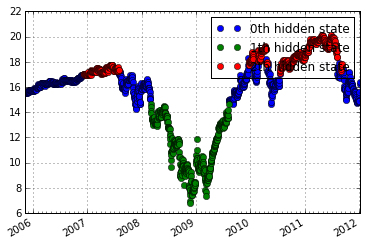

In [9]:
# unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[2] for q in quotes])[1:]

# take diff of close value
# this makes len(diff) = len(close_t) - 1
# therefore, others quantity also need to be shifted
diff = close_v[1:] - close_v[:-1]
dates = dates[1:]
close_v = close_v[1:]

# pack diff and volume for training
X = np.column_stack([diff, volume])

###############################################################################
# Run Gaussian HMM
print "fitting to HMM and decoding ...",
n_components = 3

# make an HMM instance and execute fit
model = GaussianHMM(n_components, "diag")
model.fit([X])

# predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print "done\n"

###############################################################################
# print trained parameters and plot
print "Transition matrix"
print model.transmat_
print ""

print "means and vars of each hidden state"
for i in xrange(n_components):
    print "%dth hidden state" % i
    print "mean = ", model.means_[i]
    print "var = ", np.diag(model.covars_[i])
    print ""

years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
fig = plt.figure()
ax = fig.add_subplot(111)

for i in xrange(n_components):
    # use fancy indexing to plot data in each state
    idx = (hidden_states == i)
    ax.plot_date(dates[idx], close_v[idx], 'o', label="%dth hidden state" % i)
ax.legend()

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()

# format the coords message box
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.fmt_ydata = lambda x: '$%1.2f' % x
ax.grid(True)

fig.autofmt_xdate()
plt.show()

## Kalman Filter

Kalman filters solve the learning problem like Bauch-Welch except that the hidden state variables are seen in a continuous space, rather than a discrete one. Additionally, the hidden Markov model can represent an arbitrary distribution for the next value of the state variables, in contrast to the Gaussian noise model that is used for the Kalman filter.

They are modelled on a Markov chain built on linear operators perturbed by errors that may include Gaussian noise. The state of the system is represented as a vector of real numbers. At each discrete time increment, a linear operator is applied to the state to generate the new state, with some noise mixed in, and optionally some information from the controls on the system if they are known. Then, another linear operator mixed with more noise generates the observed outputs from the true ("hidden") state.

In order to use the Kalman filter to estimate the internal state of a process given only a sequence of noisy observations, one must model the process in accordance with the framework of the Kalman filter. This means specifying the following matrices: $Fk$, the state-transition model; Hk, the observation model; $Qk$, the covariance of the process noise; $Rk$, the covariance of the observation noise; and sometimes $Bk$, the control-input model, for each time-step, $k$, as described below.


Model underlying the Kalman filter. Squares represent matrices. Ellipses represent multivariate normal distributions (with the mean and covariance matrix enclosed). Unenclosed values are vectors. In the simple case, the various matrices are constant with time, and thus the subscripts are dropped, but the Kalman filter allows any of them to change each time step.
The Kalman filter model assumes the true state at time $k$ is evolved from the state at $k−1$ according to

$$x_{k} = F_{k} x_{k-1} + B_{k} u_{k} + w_{k} $$

where

$Fk$ is the state transition model which is applied to the previous state $xk−1$;

$Bk$ is the control-input model which is applied to the control vector $uk$;

$wk$ is the process noise which is assumed to be drawn from a zero mean multivariate normal distribution with covariance $Qk$.

$w_{k} \sim N(0, Q_k) $

At time k an observation (or measurement) zk of the true state xk is made according to

$z_{k} = H_{k} x_{k} + v_{k}$

where $Hk$ is the observation model which maps the true state space into the observed space and $vk$ is the observation noise which is assumed to be zero mean Gaussian white noise with covariance $Rk$.
$v_{k} \sim N(0, R_k) $

The initial state, and the noise vectors at each step ${x0, w1, ..., wk, v1 ... vk}$ are all assumed to be mutually independent.

Many real dynamical systems do not exactly fit this model. In fact, unmodelled dynamics can seriously degrade the filter performance, even when it was supposed to work with unknown stochastic signals as inputs. The reason for this is that the effect of unmodelled dynamics depends on the input, and, therefore, can bring the estimation algorithm to instability (it diverges). On the other hand, independent white noise signals will not make the algorithm diverge. The problem of separating between measurement noise and unmodelled dynamics is a difficult one and is treated in control theory under the framework of robust control.

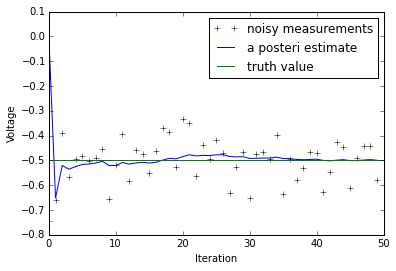

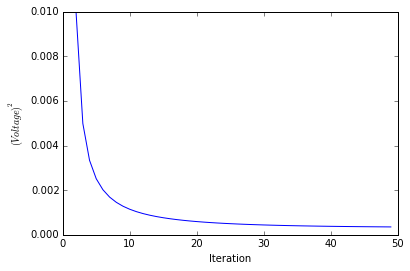

In [10]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html

# by Andrew D. Straw

import numpy
import pylab
n_iter=50

# intial parameters
sz=50
x = -.5 # truth value
z = numpy.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=numpy.zeros(sz)      # a posteri estimate of x
P=numpy.zeros(sz)         # a posteri error estimate
xhatminus=numpy.zeros(sz) # a priori estimate of x
Pminus=numpy.zeros(sz)    # a priori error estimate
K=numpy.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,sz):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

pylab.figure()
pylab.plot(z,'k+',label='noisy measurements')
pylab.plot(xhat,'b-',label='a posteri estimate')
pylab.axhline(x,color='g',label='truth value')
pylab.legend()
pylab.xlabel('Iteration')
pylab.ylabel('Voltage')

pylab.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
pylab.xlabel('Iteration')
pylab.ylabel('$(Voltage)^2$')
pylab.setp(pylab.gca(),'ylim',[0,.01])
pylab.show()

# Baysian Filtering

In many applications of HMMs, the observed data arrives sequentially over time leading to
online inference problems such as Bayesian filtering. In this case, we want to estimate the
posterior distribution $p(x_t|y_1,\ldots, y_t)$. This is the distribution over  just the current state
at time $t$ given all measurements up to and including time $t$. Note that we are not asking
here about the full history of the system state, but only the latest state. If the full history
is needed, it might be best to use MCMC methods. In the filtering task, SMC methods can
be applied efficiently because the results of the inference procedure at time $t$ can be re-used
again at time $t + 1$.

## Particle Filters

In the SMC approach to filtering, the posterior distribution over the current latent state
is based on an approximation from a finite set of samples. Particle filtering is one form of
SMC. In particle filters, each particle represents a sample or hypothesis about the current
latent state. As the number of particles increases, the approximation improves and starts to
resemble to the exact Bayesian posterior. Although a low number of particles is not desirable
for engineering applications, as it can lead to poor approximations, they can be very useful
to explain suboptimal human performance in a number of sequential tasks. Note that particle filtering does not refer to a particular algorithm that rather a general approach – there are many different methods to implement particle filters.

A particularly attractive feature of particle filters is that no memory of previous states
is needed. All the information needed for the filtering task is contained in a fixed set of
particles leading to a constant memory demand over time. However, when applying particle
filters to high-dimensional problems, a very large number of particles might be needed to
achieve good performance. This can in some cases lead to very slow performance, especially
when overly simplistic particle filters are used.

## Sample Importance Resampling (SIR)

One of the most basic particle filters is Sampling Importance Resampling (SIR). It is based
on the idea of importance sampling where a distribution is approximated by a set of samples
weighted by the density of the target function such that the dense regions of the posterior
are more heavily weighted than the tails. In the SIR filter, we always work with a fixed set
of $M$ particles. To introduce notation, let $x^i_t$ represent the hypothesis about the latent state
of the ith particle at time $t$. Across particles, we can approximate the distribution of the
filtered estimate at time $t$ by the set of particles $\{x^i_t\}$. If a point estimate is needed for the latent state, we can take the mode or mean of this distribution. 

The SIR particle filter as described below is desirable for its simplicity. It only requires that one can sample from the
state transition distribution $p(x_t|x_{t-1})$ and can evaluate the likelihood 
$p(y_t|x_t)$.

We initialize the particle filter by sampling each particle from the prior distribution
$p(x_0)$. At each iteration, we then evolve the set of particles from the last generation. First,
we sample for each particle from the last generation a candidate hypothesis for the current
latent state. Therefore, each particle leads to a projection of the hidden state to the current
time step. We then calculate the likelihood of the current observation $y_t$ under each particle.
This likelihood serves as the importance weight. We then normalize the importance weights
across particles. In the second step, we evolve the set of particles from the last generation
by sampling, with replacement, from the candidate hypotheses weighted by the importance
weights. Therefore, candidate hypotheses that make the current observations likely lead to
higher importance weights and are more likely to be sampled. This resampling continues
until $M$ new particles are generated.

Note that in the resampling step, the same proposal can be sampled multiple times. Also,
a particular proposal might not be sampled at all. Therefore, each particle can lead to a
varying number of “oﬀspring” depending on the proximity of particle to the region in state
space that best explains the current observation – bad particles die out and are taken over
by particles that do (at least for the current time step) explain the data.
In this particular version of SIR, the proposal distribution equals the state transition
distribution. This version of SIR is also known as the bootstrap or condensation algorithm.
It is important to realize that this choice of proposal distribution can lead to problems with
high-dimensional cases. This is because in the first step of the SIR approach, we sample
proposals from the state transition distribution without taking the current observation into
account. The current observation is taken into account only in the second step, by weighting
each particle by the likelihood. Therefore, we are blindly proposing how the current hidden
state evolves from the last state and then correct only afterwards for any unlikely proposals. 
In some cases, this leads to a situation where none of the candidate proposals come near
the regions in the state space that can adequately explain the current observation. In other
versions of SIR particle filters, more complex proposal distributions are used that do take
the current observation into account (in the proposal generation). Also, some authors have
proposed methods such as unscented Kalman filters to deal with this problem. The number of
particles, $M$ was set to 100. The bottom panel shows the distribution over particles for each
iteration. The middle panel shows the mode of the particles to create a point estimate for
the latent state at each time t. Importantly, remember that in the filtering task, a filtering
estimate at time t implies that all data up to and including time t has been observed.

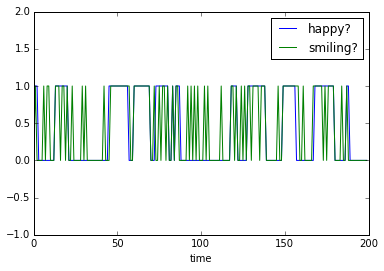

In [11]:
#let's do an example with Pavlos smiling. Pavlos can either be happy or sad. Pavlos switches moods about once every ten seconds (typical).
#If Pavlos is happy, there is a .8 chance that he will smile. If he is sad, there is only .2 chance of him smiling.

#probability that Pavlos will switch moods this second
a=.1

#probability that Pavlos will smile, given that he's happy (1-b if he's not happy)
b=.8

#we can thus generate an set of observations based on this model
Ttotal=200

#hidden states
xs = np.zeros((1,Ttotal))[0]
xs[0] = np.random.randint(2)
 
#observed states
y = np.zeros((1,Ttotal))[0]

for t in range(1,Ttotal):
    if np.random.rand() < a:
        xs[t] = 1-xs[t-1]
    else:
        xs[t] = xs[t-1]
    if xs[t]:
        if np.random.rand() < b:
            y[t] = 1
        else:
            y[t] = 0
    else:
        if np.random.rand() < 1-b:
            y[t] = 1
        else:
            y[t] = 0

plt.plot([i for i in range(Ttotal)], xs)
plt.ylim([-1,2])
plt.plot([i for i in range(Ttotal)], y)
plt.legend(['happy?', 'smiling?'])
plt.xlabel('time')


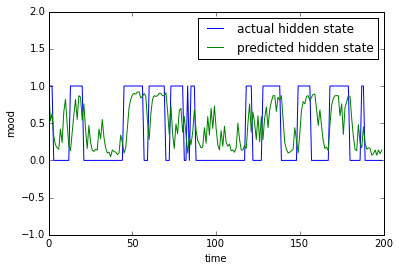

In [12]:
import numpy as np
#number of particles
M=100

xp=np.ones((M,Ttotal))
x= np.random.randint(2,size=(M,Ttotal))

#contains weights for each particle at each time step
w=np.ones((M,Ttotal))

#normalize weights
w=w/M

k=0
for t in range(1,Ttotal):
    r1 = np.random.rand(M) # a 1 x M random prob matrix
    for i in range(M):
        if r1[i] < a:
            xp[i,t] = 1-x[i,t-1] # change the predicted output
            k=k+1
        else:
            xp[i,t] = x[i,t-1] # don't change the predicted output
        # generate weight based on observation likelihood
        if y[t] == xp[i,t]:
            w[i,t] = b
        else:
            w[i,t] = 1-b
    #normalize
    w[:,t] = w[:,t] / sum(w[:,t])
    
    #generate M new particles
    j=0
    while j < M-1:
        i = np.random.randint(M)
        if np.random.rand() < w[i,t]:
            x[j,t] = xp[i,t]
            j = j+1

# calculte the averaged predicted hidden state
pred = np.zeros(Ttotal)
for t in range(Ttotal):
    pred[t] = (sum(xp[:,t])/M)

#plot the results
plt.plot([i for i in range(Ttotal)], xs)
plt.ylim([-1,2])
plt.plot([i for i in range(Ttotal)], pred)
plt.legend(['actual hidden state', 'predicted hidden state'])
plt.xlabel('time')
plt.ylabel('mood')
